# Database Analysis

In [1]:
import lmdb
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
tqdm.pandas()

## Tokenize Code

We will use TreeSitter to tokenize our Java code.

In [3]:
!mkdir -p ./third_party
!cd third_party && git clone https://github.com/tree-sitter/tree-sitter-java.git

fatal: destination path 'tree-sitter-java' already exists and is not an empty directory.


In [ ]:
from tree_sitter import Language
Language.build_library('./language-parser.so', ["third_party/tree-sitter-java"])

In [3]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
jprocessor = JavaProcessor(root_folder='./third_party')

/scr/abaveja/miniconda3/envs/m2t/lib/python3.8/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


#### Load Dataset

In [4]:
from dataset_utils import get_or_create_df

df = get_or_create_df(df_path='/sailhome/abaveja/df.feather')
preserved_cols = ['focal_class.identifier', 'focal_method.cm_signature', 'focal_method.body', 'repository.url']

In [5]:
tests_per_method = df.groupby(['repository.url', 'focal_method.cm_signature']).size()

#### Tokenize Loaded Functions

In [6]:
methods = df[preserved_cols].groupby(['repository.url', 'focal_method.cm_signature']).first()

In [7]:
def tokenize(row):
    return jprocessor.tokenize_code(
        row['focal_method.body'],
        process_strings=True,
        keep_comments=False
    )
    
methods['focal_method.tokenized_body'] = methods.progress_apply(tokenize, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403476/403476 [01:47<00:00, 3750.68it/s]


In [8]:
methods.head(2)

,,focal_class.identifier,focal_method.body,focal_method.tokenized_body
repository.url,focal_method.cm_signature,,,
https://github.com/00-matt/moneropool,DifficultyCalculator.getNextJobDifficulty(Miner miner),DifficultyCalculator,public Difficulty getNextJobDifficulty(Miner m...,"[public, Difficulty, getNextJobDifficulty, (, ..."
https://github.com/0604hx/nerve-tools,Countries.get(String nameOrCode),Countries,public final static CountryBean get(String nam...,"[public, final, static, CountryBean, get, (, S..."


## Remove Duplicates
We use the following algorithm to remove duplicates
> 1. Calculate pairwise *Jaccard similarity* between all programs in the dataset (make symmetric assumption)
2. Cluster programs based on their Jaccard similarity
3. Define a set of new programs
4. For each cluster, add the program with the highest number of unit tests to the program set. Ties are broken via uniform random sampling among the best-tested programs.
5. Add all programs with no cluster to the set

In [9]:
from dpu_utils.codeutils.deduplication import DuplicateDetector
import random

random.seed(42)

detector = DuplicateDetector(
    set_similarity_threshold=0.8,
    multiset_similarity_threshold=0.7,
    min_num_tokens_per_document=20
)

for method_key, method in tqdm(methods.iterrows(), total=len(methods)):
    detector.add_file(
        id='\0'.join(method_key), # use null ascii char because that will never be in signature or repo URL
        tokens=method['focal_method.tokenized_body'],
        language='java'
    )

clusters = detector.compute_duplicates()  # List[Set[example_id]]
detector.print_clone_set_stats(clusters)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403476/403476 [00:37<00:00, 10769.34it/s]


Duplicated files: 18.57%
Avg num of files per clones 2.50
Median num of files per clones 2.0
Duplication Ratio 11.13%


#### Deduplication Heuristic
To Deduplicate Code Clusters, we will only preserve the cluster with the highest number of tests. Ties will be broken by taking a random sample from the maximum category.

In [152]:
from collections import defaultdict

centroids = set()
# Take a 
for c in clusters:
    counts = defaultdict(list)
    for ex_id in c:
        key = tuple(ex_id.split('\0'))
        counts[tests_per_method[key]].append(ex_id)
        
    max_key = max(counts.keys())
    centroid = random.choice(list(counts[max_key]))
    centroids.add(centroid)
    
clustered_ex_ids = {ex_id for c in clusters for ex_id in c}
for method_key, method in tqdm(methods.iterrows(), total=len(methods)):
    joint_key = '\0'.join(method_key)
    if joint_key not in clustered_ex_ids:
        centroids.add(joint_key)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403476/403476 [00:14<00:00, 27433.06it/s]


In [153]:
print("Statistics")
print("-"*30)
print("Number of methods", len(methods))
print("Number of clusters", len(centroids))
print("Duplicate Percentage", f"{round((1-(len(centroids)/len(methods)))*100, 2)}%")

Statistics
------------------------------
Number of methods 403476
Number of clusters 383975
Duplicate Percentage 4.83%


## Load Query Results

In [204]:
import pickle

def get_rows(env_file):
    with lmdb.open(env_file, readonly=True) as env:
        data = []
        with env.begin() as txn:
            for key, value in txn.cursor():
                value = pickle.loads(value)
                if value['t'] == 'method':
                    parsed_key = key.decode('utf-8').split('\0')
                    key_cols = {'repository.name': parsed_key[0], 'focal_method.cm_signature': parsed_key[1]}
                    row = dict(**key_cols, **value)
                    row['key'] = key.decode('utf-8')
                    data.append(row)
        return data
    

rows_matx1 = get_rows('/matx/u/abaveja/query_results_matx1/')
rows_matx2 = get_rows('/matx/u/abaveja/query_results_matx2/')

rows = rows_matx1 + rows_matx2
sa_results = pd.DataFrame(rows)

In [205]:
sa_results = sa_results[sa_results['key'].isin(centroids)]

In [206]:
sa_results

,repository.name,focal_method.cm_signature,field_accesses,field_writes,same_class_other_invoc,diff_class_known_invoc,diff_class_unknown_invoc,branch_count,lambda_functional_count,special_method_access_count,...,cyclomatic_complexity,efferent_coupling,afferent_coupling,maintainability_index,maintainability_index_no_comments,num_params,num_lines_code,gsig,t,key
0,https://github.com/163yun/cloud-native-app-sample,GitHubApiController.discoverUserByScreenName(@...,1,0,0,0,2,0,0,0,...,1,4,0,99.186561,99.186561,1,4,discoverUserByScreenName(String),method,https://github.com/163yun/cloud-native-app-sam...
1,https://github.com/Activiti/activiti-core-common,ApplicationDeployer.deploy(),2,0,0,0,2,0,0,0,...,3,2,1,97.023723,97.023723,0,8,deploy(),method,https://github.com/Activiti/activiti-core-comm...
3,https://github.com/Activiti/activiti-core-common,ApplicationService.loadApplications(),2,0,0,0,4,0,0,0,...,3,6,4,89.095658,89.095658,0,14,loadApplications(),method,https://github.com/Activiti/activiti-core-comm...
4,https://github.com/Activiti/activiti-core-common,ConnectorDefinitionService.validate(List<Conne...,0,0,0,0,5,4,0,0,...,7,8,5,68.181024,68.181024,1,17,validate(List<ConnectorDefinition>),method,https://github.com/Activiti/activiti-core-comm...
5,https://github.com/Activiti/activiti-core-common,SecurityPoliciesProcessInstanceRestrictionAppl...,0,0,0,0,3,0,0,0,...,1,3,1,76.314758,100.718866,1,3,restrictToKeys(Set<String>),method,https://github.com/Activiti/activiti-core-comm...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,https://github.com/sockeqwe/AdapterDelegates,AdapterDelegatesManager.getViewType(@NonNull A...,1,0,0,0,0,2,0,0,...,3,1,3,-5.274872,31.602018,1,10,getViewType(<any>),method,https://github.com/sockeqwe/AdapterDelegates A...
3094,https://github.com/sockeqwe/AdapterDelegates,AdapterDelegatesManager.onBindViewHolder(@NonN...,1,0,1,0,2,1,0,0,...,3,3,3,-5.274872,31.602018,4,12,"onBindViewHolder(T, int, ViewHolder, List<>)",method,https://github.com/sockeqwe/AdapterDelegates A...
3095,https://github.com/sockeqwe/AdapterDelegates,AdapterDelegatesManager.onCreateViewHolder(@No...,0,0,1,0,0,2,0,0,...,3,2,6,-5.274872,31.602018,2,15,"onCreateViewHolder(ViewGroup, int)",method,https://github.com/sockeqwe/AdapterDelegates A...
3097,https://github.com/sockeqwe/AdapterDelegates,AdapterDelegatesManager.onViewDetachedFromWind...,0,0,1,0,3,1,0,0,...,2,4,3,-5.274872,31.602018,1,12,onViewDetachedFromWindow(ViewHolder),method,https://github.com/sockeqwe/AdapterDelegates A...


In [234]:
sa_results['difference_from_zero'] = sa_results['maintainability_index'].abs()

# Find the index of the minimum difference
min_diff_index = sa_results['branch_count'].idxmax()

# Retrieve the row with the smallest absolute difference from zero
closest_to_zero_row = sa_results.loc[min_diff_index]

In [237]:
closest_to_zero_row

repository.name                                      https://github.com/IGNF/geoxygene
focal_method.cm_signature                               CarteTopo.creeTopologieFaces()
field_accesses                                                                       2
field_writes                                                                         0
same_class_other_invoc                                                              19
diff_class_known_invoc                                                               0
diff_class_unknown_invoc                                                            13
branch_count                                                                        39
lambda_functional_count                                                              0
special_method_access_count                                                          0
special_control_flow_count                                                           0
special_literals_count                     

In [241]:
print(methods.loc[(closest_to_zero_row['repository.name'], closest_to_zero_row['focal_method.cm_signature'])]['focal_method.body'])

@SuppressWarnings("unchecked")
  public void creeTopologieFaces() {
    List<Arc> arcsDejaTraitesADroite = new ArrayList<Arc>();
    List<Arc> arcsDejaTraitesAGauche = new ArrayList<Arc>();
    List<Arc> arcsDuCycle;
    List<Boolean> orientationsArcsDuCycle;
    ILineString geometrieDuCycle;
    IPopulation<Face> popFaces = this.getPopFaces();
    List<Cycle> cycles = new ArrayList<Cycle>();
    this.fireActionPerformed(
        new ActionEvent(this, 0, I18N.getString("CarteTopo.FaceTopologyEdges"), //$NON-NLS-1$
            this.getPopArcs().size()));
    int iteration = 0;
    /*
     * Parcours de tous les arcs du graphe. Puis, pour chaque arc: - recherche
     * du cycle à droite et du cycle à gauche - creation des faces
     * correspondantes - on note les arcs par lesquels on est déjà passé pour ne
     * pas refaire le travail TODO Regrouper le traitement à droite et à gauche
     * des arcs.
     */
    for (Arc arc : this.getPopArcs()) {
      Face face = null;
      // a dro

In [220]:
methods

focal_class.identifier  \
repository.url                        focal_method.cm_signature                                                   
https://github.com/00-matt/moneropool DifficultyCalculator.getNextJobDifficulty(Miner...   DifficultyCalculator   
https://github.com/0604hx/nerve-tools Countries.get(String nameOrCode)                                Countries   
                                      DFile.parse(final File file)                                        DFile   
                                      DFile.toMap()                                                       DFile   
                                      SSHFactory.execRemoteBooeEntity(\n\t\t\tIMessag...             SSHFactory   
...                                                                                                         ...   
https://github.com/zzt93/syncer       RegexUtil.getRegex(String input)                                RegexUtil   
                                      SQLHelper.alterMeta(String database, String sql)                SQLHelper   
                                      SyncData.recycleParseContext(ThreadLocal<Standa...               SyncData   
                                      SyncData.updated()                                               SyncData   
                                      SyncKafkaSerializer.serialize(String topic, Syn...    SyncKafkaSerializer   

                                                                                                                          focal_method.body  \
repository.url                        focal_method.cm_signature                                                                               
https://github.com/00-matt/moneropool DifficultyCalculator.getNextJobDifficulty(Miner...  public Difficulty getNextJobDifficulty(Miner m...   
https://github.com/0604hx/nerve-tools Countries.get(String nameOrCode)                    public final static CountryBean get(String nam...   
                                      DFile.parse(final File file)                        public static DFile parse(final File file){\n\...   
                                      DFile.toMap()                                       public Map<String, Object> toMap(){\n\t\tif(ge...   
                                      SSHFactory.execRemoteBooeEntity(\n\t\t\tIMessag...  public static void execRemoteBooeEntity(\n\t\t...   
...                                                                                                                                     ...   
https://github.com/zzt93/syncer       RegexUtil.getRegex(String input)                    public static Pattern getRegex(String input) {...   
                                      SQLHelper.alterMeta(String database, String sql)    public static AlterMeta alterMeta(String datab...   
                                      SyncData.recycleParseContext(ThreadLocal<Standa...  public void recycleParseContext(ThreadLocal<St...   
                                      SyncData.updated()                                  @Override\n  public boolean updated() {\n    r...   
                                      SyncKafkaSerializer.serialize(String topic, Syn...  @Override\n  public byte[] serialize(String to...   

                                                                                                                focal_method.tokenized_body  
repository.url                        focal_method.cm_signature                                                                              
https://github.com/00-matt/moneropool DifficultyCalculator.getNextJobDifficulty(Miner...  [public, Difficulty, getNextJobDifficulty, (, ...  
https://github.com/0604hx/nerve-tools Countries.get(String nameOrCode)                    [public, final, static, CountryBean, get, (, S...  
                                      DFile.parse(final File file)                        [public, static, DFile, parse, (, final, File,...  
                       

## Data Visualization
1. Distribution of maintainability index (show highest, show lowest)
2. Distribution of afferent and efferent coupling
3. Distribution of cyclomatic complexity
4. Quartiles of special features

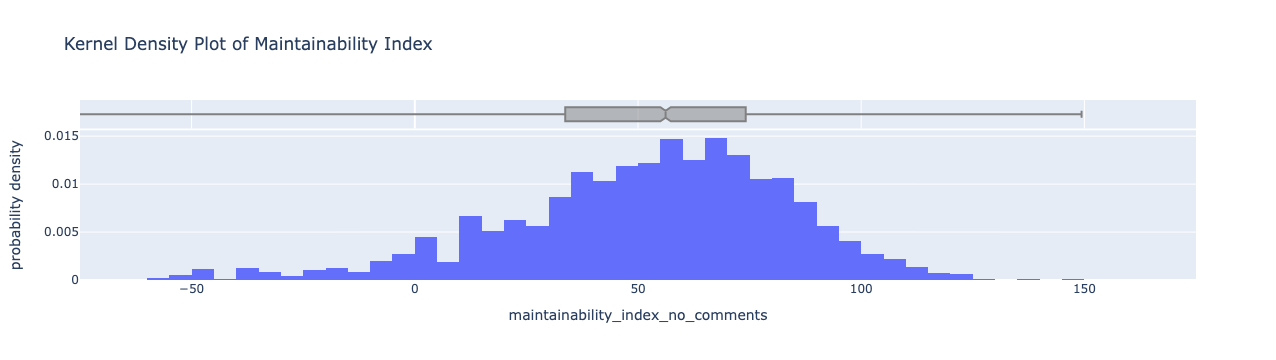

In [215]:
import plotly.express as px

# Assuming 'sa_results' is a DataFrame and 'maintainability_index' is a column in it
fig = px.histogram(sa_results, x="maintainability_index_no_comments",
                   title="Kernel Density Plot of Maintainability Index",
                   histnorm='probability density',
                   marginal='box',
                   hover_data=sa_results.columns)

# Set x-axis range to focus on central data, excluding extreme values
# You would replace 'min_value' and 'max_value' with the actual values you consider appropriate
fig.update_xaxes(range=[-75, 175])

# Hide outliers in the marginal box plot
fig.data[1].boxpoints = False  # Hide outlier points in the box plot
fig.data[1].marker.color = 'gray'  # Change color of the marginal box plot

fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['repository.name', 'focal_method.cm_signature', 'field_accesses', 'field_writes', 'same_class_other_invoc', 'diff_class_known_invoc', 'diff_class_unknown_invoc', 'branch_count', 'lambda_functional_count', 'special_method_access_count', 'special_control_flow_count', 'special_literals_count', 'special_incdec_count', 'special_patterns_count', 'halstead_length', 'halstead_vocab', 'cyclomatic_complexity', 'efferent_coupling', 'afferent_coupling', 'maintainability_index', 'maintainability_index_no_comments', 'num_params', 'num_lines_code', 'gsig', 't', 'key'] but received: maintainability_index_no_coments

In [187]:
cat /matx/u/abaveja/stats2.json

{
  "completed_repo": 84,
  "completed_method": 1113,
  "completed_testcase": 2042,
  "failed_repo": 6,
  "failed_method": null,
  "failed_testcase": null
}


In [160]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 63.3 MB/s eta 0:00:00:00:0100:01
